# Text Classification using fine-tuned GPT-2 model

In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import gc
import spacy
from spacy import displacy

import plotly.express as px

import random

## Load Combined Data

In [2]:
df = pd.read_csv('../../../Sample_Data/For_Modeling/sarealfakenews_dataset/Combined_Data.csv')
df.head()

title  \
0        Tsietsi Mashinini speaks on Soweto uprising   
1  Parliament's tourism committee to question Tot...   
2  VIDEO: ANC Are Punch Drunk on Emergency Powers...   
3  This is why Mpumalanga is repurposing some TB ...   
4  Ramaphosa Cares More For Vicious Farm Attacker...   

                                                text  \
0  Image: Tsietsi Mashinini \nBy BO Staff Writer\...   
1  The National Assembly's Portfolio Committee on...   
2  Local KDM traffic officers in KZN are punch dr...   
3  The Mpumalanga health department plans to repu...   
4  Ramaphosa told Bloomberg News in New York in 2...   

                                                 url        medium label  
0  https://blackopinion.co.za/category/intnews/fe...  blackopinion  fake  
1  https://www.news24.com/news24/politics/parliam...        news24  real  
2  https://sa-news.com/video-anc-are-punch-drunk-...       sa-news  fake  
3  https://www.news24.com/news24/health/spotlight...        news24  real  
4  https://sa-news.com/ramaphosa-cares-more-for-v...       sa-news  fake

Text(0.5, 1.0, 'Distribution of News sources(Medium)')

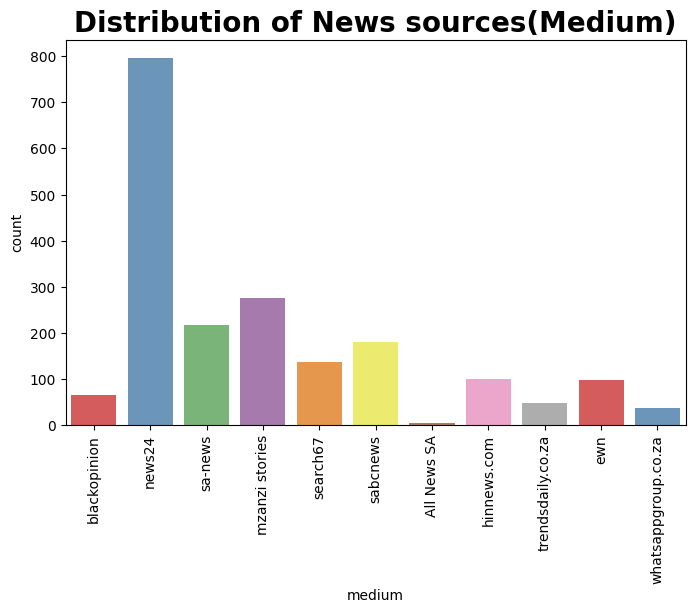

In [3]:
plt.figure(figsize = (8,5))
sns.countplot(x = df['medium'], palette = 'Set1', alpha = 0.8)
plt.xticks(rotation=90)
plt.title('Distribution of News sources(Medium)',fontsize=20, fontweight='bold')

## Preprocessing data (text tokenization)

* We need to tokenize the input text in order to feed GPT-2 model with its expected data format.<br> 
  This can be easily done using HuggingFace Transformers' GPT2Tokenizer object. However, unlike <br>
  BERT which does padding to the right, for GPT-2 we need to do padding to the left, because we <br>
  need to use the last token for prediction. Therefore we need to adapt GPT2Tokenizer after calling. <br>

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [5]:
example_text = "I will watch Memento tonight"
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [6]:
print(gpt2_input['input_ids'])

tensor([[50256, 50256, 50256,    40,   481,  2342,   337,   972,    78,  9975]])


In [7]:
print(gpt2_input["attention_mask"])

tensor([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


In [8]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

<|endoftext|><|endoftext|><|endoftext|>I will watch Memento tonight


# Dataset class
* PyTorch provides a very convenient way to construct cusom Dataset class to facilitate model training.<br> 
  See more details here. Here we will build a custom Dataset class to read in our news data, tokenize them, <br> 
  and store them into containers for batch training.

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {"real": 0,"fake": 1}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## Split training-test dataset
* One more thing to do before we start with models. We need to split train, validation and test data as separate dataframes. Numpy's split function can do just that.

In [10]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=35),
                                     [int(0.8*len(df)), int(0.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

1564 196 196


# Model building
* Now comes to the most important part of this notebook. 
  We need to buid a classifier model on top of a pre-trained GPT-2 model. <br>
  The trick here is to add a linear layer on top of GPT-2's 12 layers of decoders <br> 
  with its output dimension equals our number of labels. <br>
  In this way we can use GPT-2 to output 2 numbers which corresponds to our two news classes (**FAKE/ REAL**)! <br>

For more information about how to build customized models in PyTorch, see here.

In [11]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

# Training loop
* Now it's time to train (fine-tune) our model! Here I build a standard PyTorch training loop following this guide. <br> 
  Since this is a multi-class classification problem, I picked cross-entropy-loss as our loss function ("criterion"), <br>
  and Adam as the optimization algorithm. <br>

In [12]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

In [12]:
            
EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|█████████████████████████████████████████| 782/782 [01:01<00:00, 12.72it/s]


Epochs: 1 | Train Loss:  0.217             | Train Accuracy:  0.820             | Val Loss:  0.023             | Val Accuracy:  0.990


* Looks like the model is already well trained after 1 epoch! <br>
  This is probably due to the fact that as a pre-trained model with gigantic number of parameters, <br>
  GPT-2 is already capable of differentiating different text paragraphs without too much tuning

# Evaluation
* After model training, it's recommended to use the test data to evaluate the model<br>
  performance on unseen data. I build the evaluate function according this PyTorch guide.

In [20]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        print(f'GPU NAME: {torch.cuda.get_device_name()}')
        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels

In [21]:
true_labels, pred_labels = evaluate(model, df_test)

GPU NAME: Quadro RTX 4000 with Max-Q Design
Test Accuracy:  0.964


* Another good gauge of model performance is the confusion matrix.

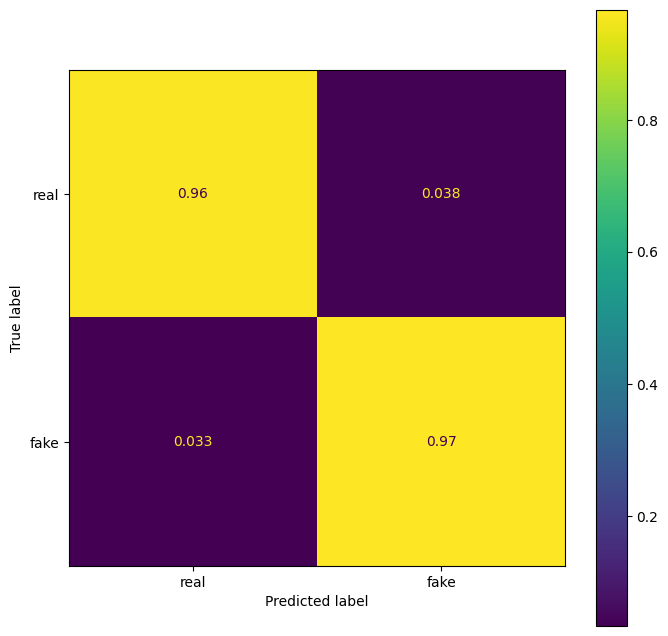

In [17]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

## Saving and loading the model
* After training, we need to save the model locally. <br>
  PyTorch models store the learned parameters in an internal state dictionary, called state_dict.<br> 
  These can be persisted via the torch.save method:

In [18]:
# save trained model
torch.save(model.state_dict(), "./gpt2-text-classifier-model.pt")

* To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In [19]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=2, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("./gpt2-text-classifier-model.pt"))
model_new.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dr

## Model Inference
* Here we want to use the model to generate inferences. Here we use a clipped news from BBC Politics as an example.